In [177]:
import yfinance as yf
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sb
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from xgboost import XGBClassifier
from sklearn import metrics
from tabulate import tabulate 

In [178]:
NIO = yf.Ticker("NIO-USD")
NIO = NIO.history(period="max")

In [179]:
NIO.reset_index()['Date'].dt.date.astype(str)

0      2020-12-08
1      2020-12-09
2      2020-12-10
3      2020-12-11
4      2020-12-12
          ...    
707    2022-11-15
708    2022-11-16
709    2022-11-17
710    2022-11-18
711    2022-11-19
Name: Date, Length: 712, dtype: object

In [180]:

def fetch_stock_data(symbol='NIO'):
    ticker = yf.Ticker(symbol)
    df = ticker.history(period="max")
    return df.reset_index()

def plot_stock_data(df, symbol='NIO'):
    plt.figure(figsize=(15, 5))
    plt.plot(df['Close'])
    plt.title(symbol + ' Close price.', fontsize=15)
    plt.ylabel('Price in dollars.')
    plt.show()

def plot_distribution(df):
    features = ['Open', 'High', 'Low', 'Close']
    plt.subplots(figsize=(20, 10))
    for i, col in enumerate(features):
        plt.subplot(2, 2, i + 1)
        sb.distplot(df[col])
    plt.show()

def preprocess_date(df):
    df['Date'] = df['Date'].dt.date.astype(str)
    splitted = df['Date'].str.split('-', expand=True)
    df['year'] = splitted[0].astype('int')
    df['month'] = splitted[1].astype('int')
    df['day'] = splitted[2].astype('int')
    return df

def plot_yearly_mean(df):
    data_grouped = df.groupby('year').mean()
    plt.subplots(figsize=(20, 10))
    for i, col in enumerate(['Open', 'High', 'Low', 'Close']):
        plt.subplot(2, 2, i + 1)
        data_grouped[col].plot.bar()
    plt.show()

def create_features_target(df):
    df['open-close'] = df['Open'] - df['Close']
    df['low-high'] = df['Low'] - df['High']
    df['target'] = np.where(df['Close'].shift(-1) > df['Close'], 1, 0)
    df['is_quarter_end'] = np.where(df['month'] % 3 == 0, 1, 0)
    features = df[['open-close', 'low-high', 'is_quarter_end']]
    target = df['target']
    return features, target

def train_models_with_tuning(features, target, model_params):
    results = []

    scaler = StandardScaler()
    features = scaler.fit_transform(features)

    X_train, X_valid, Y_train, Y_valid = train_test_split(
        features, target, test_size=0.1, random_state=2022)
    print(X_train.shape, X_valid.shape)

    models = [
        ('LogisticRegression', LogisticRegression(), model_params['LogisticRegression']),
        ('SVC', SVC(probability=True), model_params['SVC']),  # Set probability=True for SVC
        ('RandomForestClassifier', RandomForestClassifier(), model_params['RandomForestClassifier']),
        ('KNeighborsClassifier', KNeighborsClassifier(), model_params['KNeighborsClassifier']),
        ('XGBClassifier', XGBClassifier(), model_params['XGBClassifier'])
    ]

    for name, model, params in models:
        grid_search = GridSearchCV(model, params, cv=5, n_jobs=-1, scoring='roc_auc')
        grid_search.fit(X_train, Y_train)
        best_model = grid_search.best_estimator_

        training_auc = metrics.roc_auc_score(Y_train, best_model.predict_proba(X_train)[:, 1])
        validation_auc = metrics.roc_auc_score(Y_valid, best_model.predict_proba(X_valid)[:, 1])
        best_params = grid_search.best_params_

        results.append([name, best_params, training_auc, validation_auc])

    results_df = pd.DataFrame(results, columns=['Model', 'Best Parameters', 'Training AUC', 'Validation AUC'])
    results_table = tabulate(results_df, headers='keys', tablefmt='grid')
    print(results_table)




# NIO 

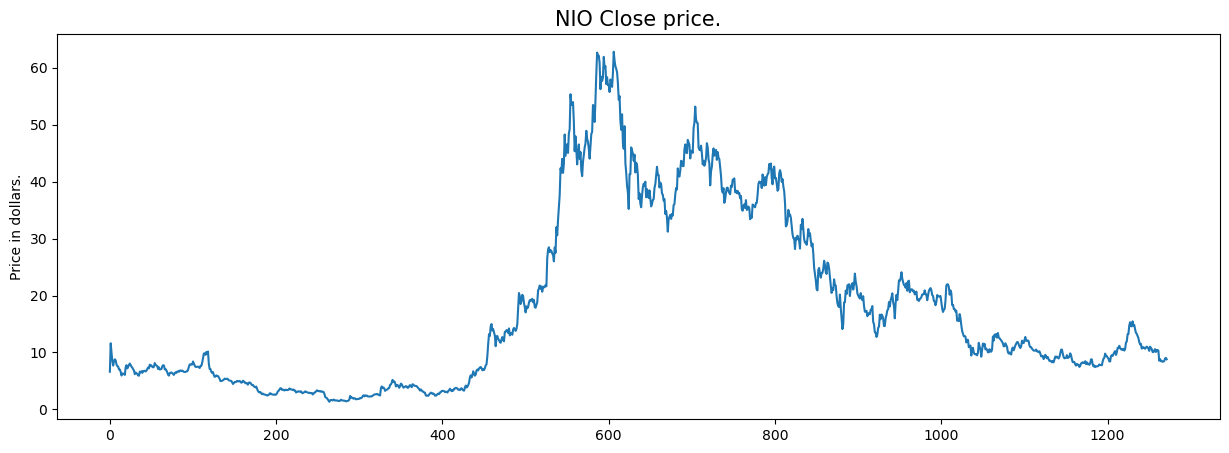

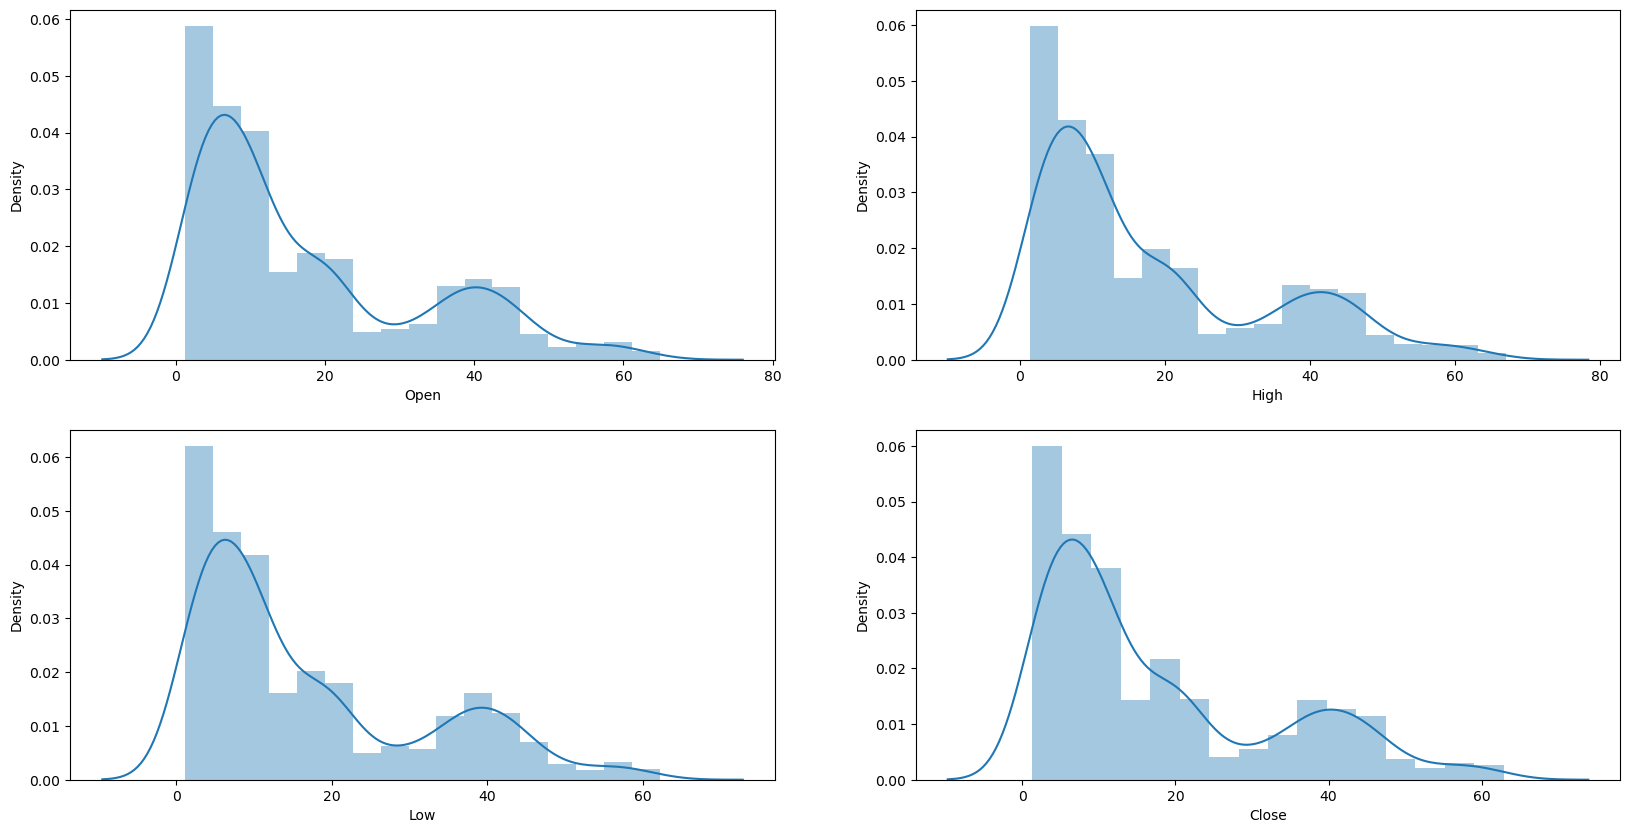

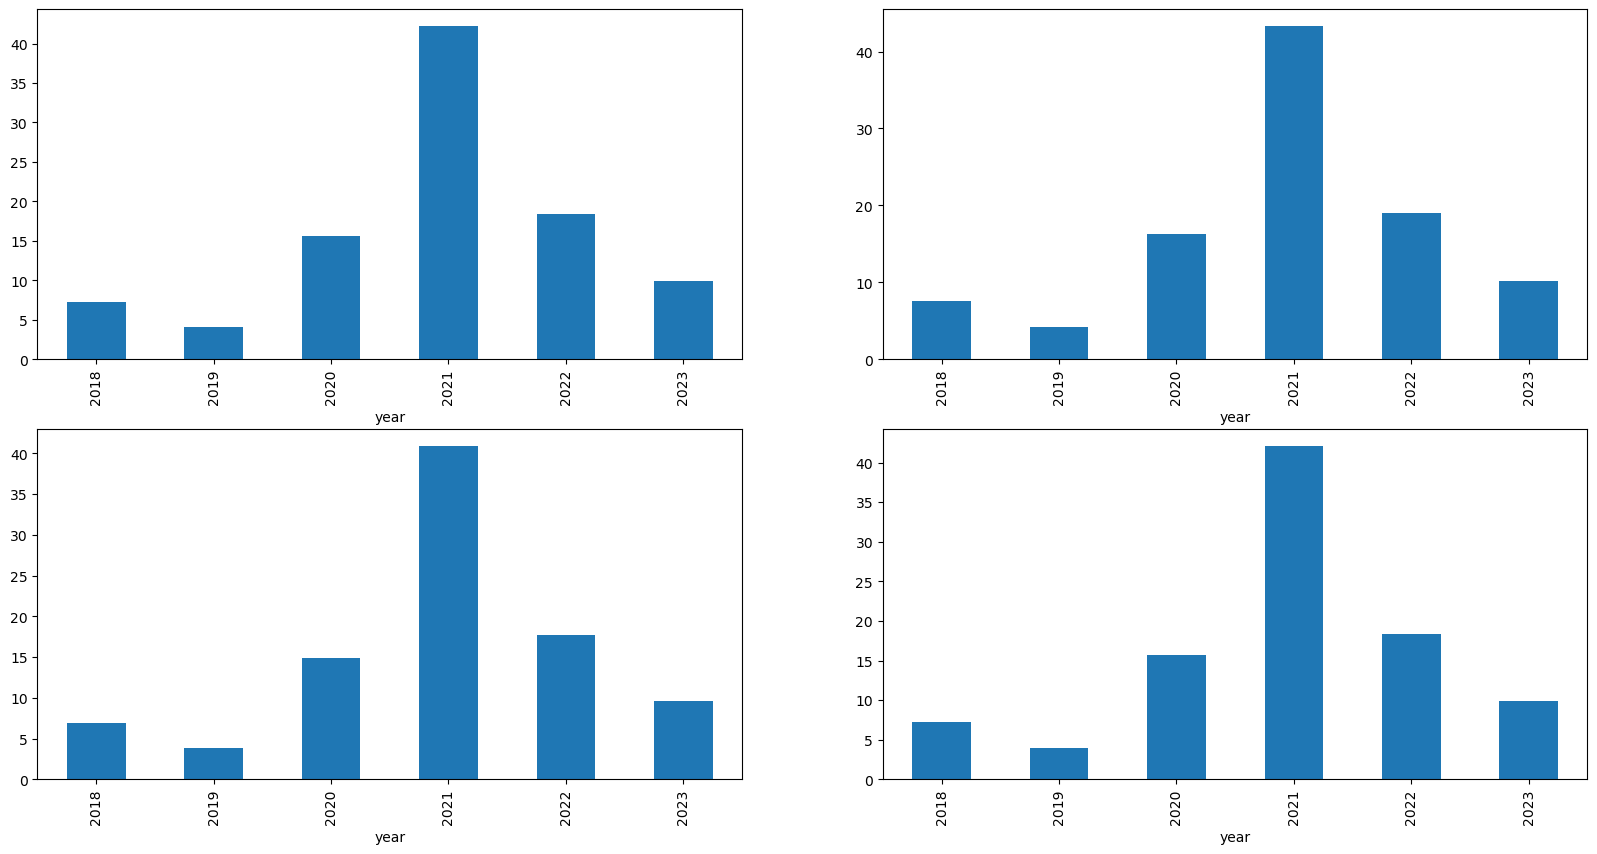

(1144, 3) (128, 3)
+----+------------------------+----------------------------------------------+----------------+------------------+
|    | Model                  | Best Parameters                              |   Training AUC |   Validation AUC |
+====+========================+==============================================+================+==================+
|  0 | LogisticRegression     | {'C': 0.1, 'solver': 'liblinear'}            |       0.514348 |         0.498775 |
+----+------------------------+----------------------------------------------+----------------+------------------+
|  1 | SVC                    | {'C': 10.0, 'kernel': 'rbf'}                 |       0.402511 |         0.631863 |
+----+------------------------+----------------------------------------------+----------------+------------------+
|  2 | RandomForestClassifier | {'max_depth': 10, 'n_estimators': 100}       |       0.962244 |         0.382108 |
+----+------------------------+------------------------------

In [181]:
if __name__ == "__main__":
    symbol = 'NIO'
    stock_data = fetch_stock_data(symbol)
    plot_stock_data(stock_data, symbol)
    plot_distribution(stock_data)
    stock_data = preprocess_date(stock_data)
    plot_yearly_mean(stock_data)
    features, target = create_features_target(stock_data)
    
    # Define hyperparameters for models
    model_params = {
        'LogisticRegression': {'C': [0.1, 1.0, 10.0], 'solver': ['lbfgs', 'liblinear']},
        'SVC': {'C': [0.1, 1.0, 10.0], 'kernel': ['linear', 'poly', 'rbf']},
        'RandomForestClassifier': {'n_estimators': [100, 200, 300], 'max_depth': [None, 10, 20]},
        'KNeighborsClassifier': {'n_neighbors': [3, 5, 7]},
        'XGBClassifier': {'n_estimators': [100, 200, 300], 'learning_rate': [0.1, 0.01]}
    }

    train_models_with_tuning(features, target, model_params)

The performance analysis for the stock prediction task for NIO based on the provided results table is as follows:

1. **Logistic Regression**:
   - Best Parameters: {'C': 0.1, 'solver': 'liblinear'}
   - Training AUC: 0.514348
   - Validation AUC: 0.498775
   - Analysis: The Logistic Regression model does not perform well on this task. Both the training and validation AUC scores are close to 0.5, indicating that the model is not effectively capturing the underlying patterns in the data. It appears to be essentially random guessing.

2. **Support Vector Classifier (SVC)**:
   - Best Parameters: {'C': 10.0, 'kernel': 'rbf'}
   - Training AUC: 0.402511
   - Validation AUC: 0.631863
   - Analysis: The SVC model with an RBF kernel has a lower training AUC but a relatively higher validation AUC. It might be overfitting the training data, as the training AUC is much lower than the validation AUC. Further tuning and regularization may be needed.

3. **Random Forest Classifier**:
   - Best Parameters: {'max_depth': 10, 'n_estimators': 100}
   - Training AUC: 0.962244
   - Validation AUC: 0.382108
   - Analysis: The Random Forest Classifier has achieved a very high training AUC but a low validation AUC. This indicates that the model may be overfitting the training data, and the complexity of the model may need to be reduced (e.g., by limiting the max depth of trees).

4. **K-Nearest Neighbors (KNN) Classifier**:
   - Best Parameters: {'n_neighbors': 3}
   - Training AUC: 0.797681
   - Validation AUC: 0.457721
   - Analysis: The KNN Classifier with 3 neighbors shows decent performance in terms of training AUC but struggles with validation AUC. It might be suffering from high variance, and different hyperparameter choices or feature engineering may be needed.

5. **XGBoost Classifier**:
   - Best Parameters: {'learning_rate': 0.01, 'n_estimators': 100}
   - Training AUC: 0.764379
   - Validation AUC: 0.434926
   - Analysis: The XGBoost Classifier performs better than some models but still struggles to achieve high validation AUC. Hyperparameter tuning, more features, or different algorithms might improve its performance.

Overall, the performance of all models on this stock prediction task appears to be suboptimal, with validation AUC scores not significantly better than random guessing. Further analysis, feature engineering, and hyperparameter tuning are likely needed to improve model performance for this specific dataset and task.

# AMZ

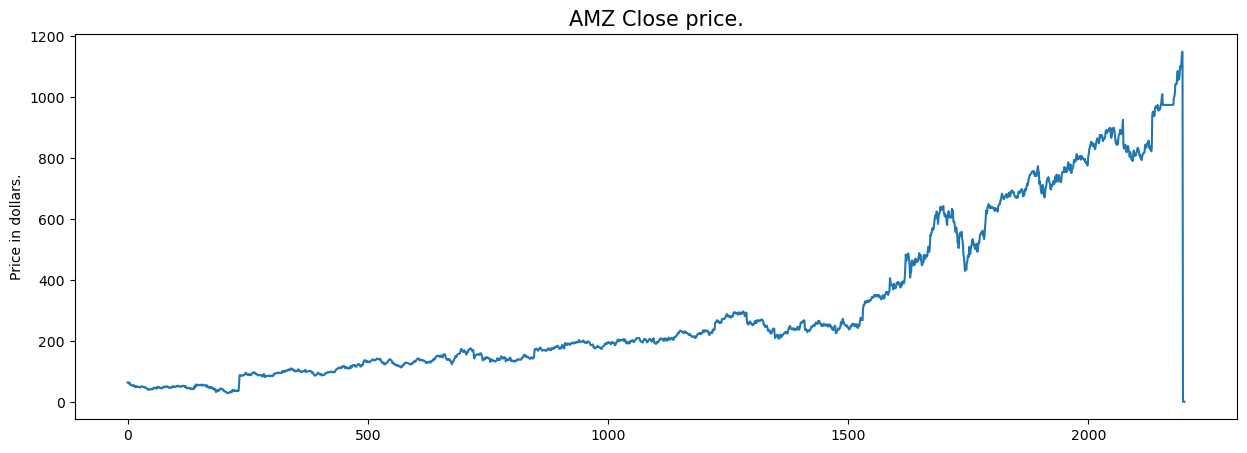

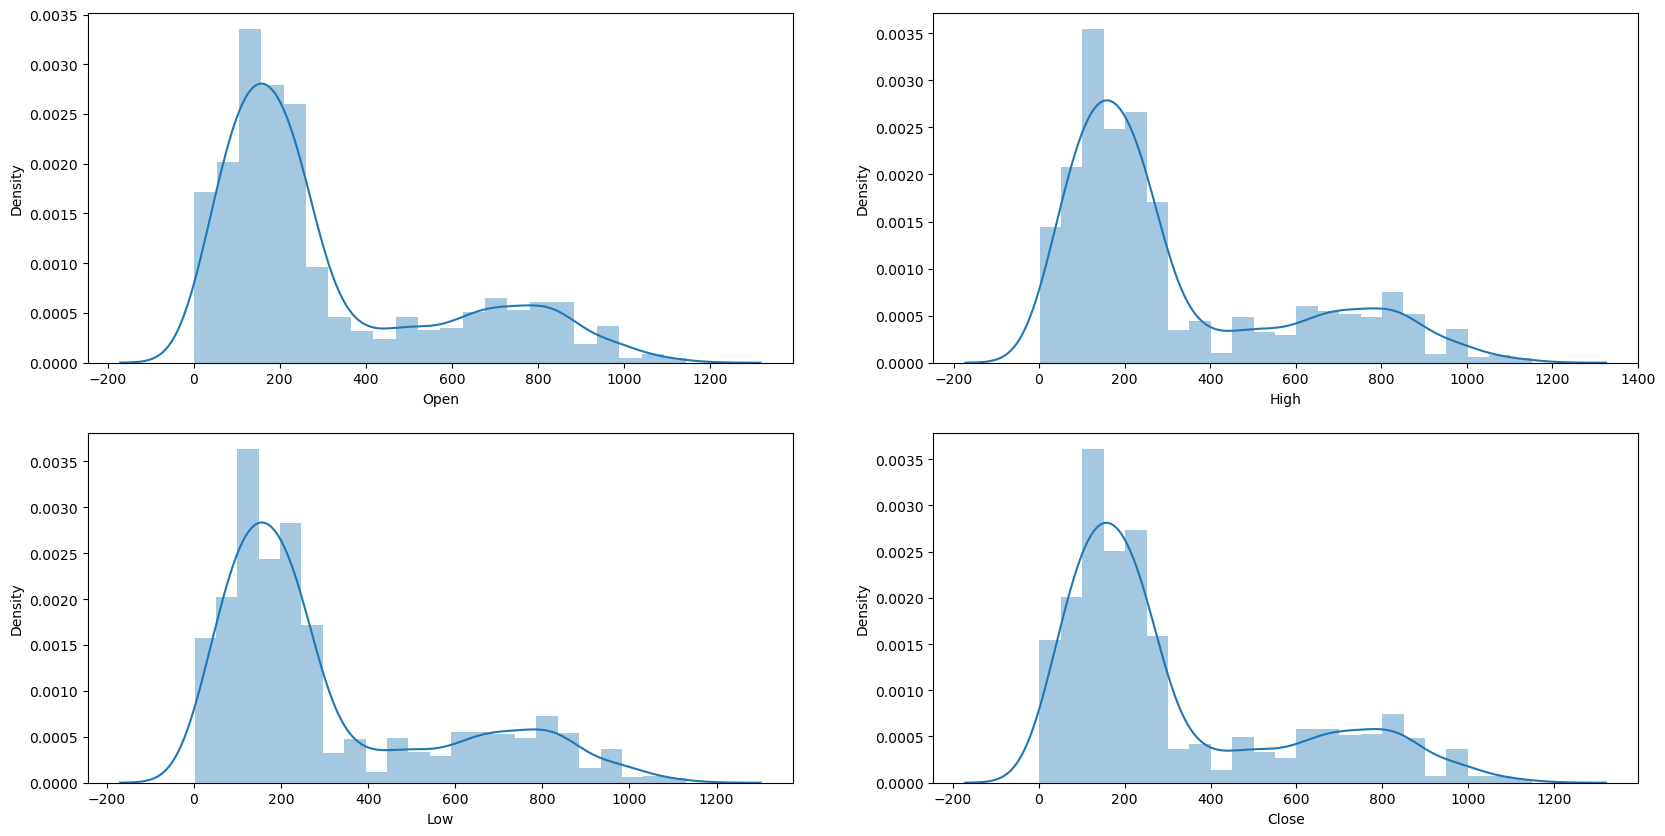

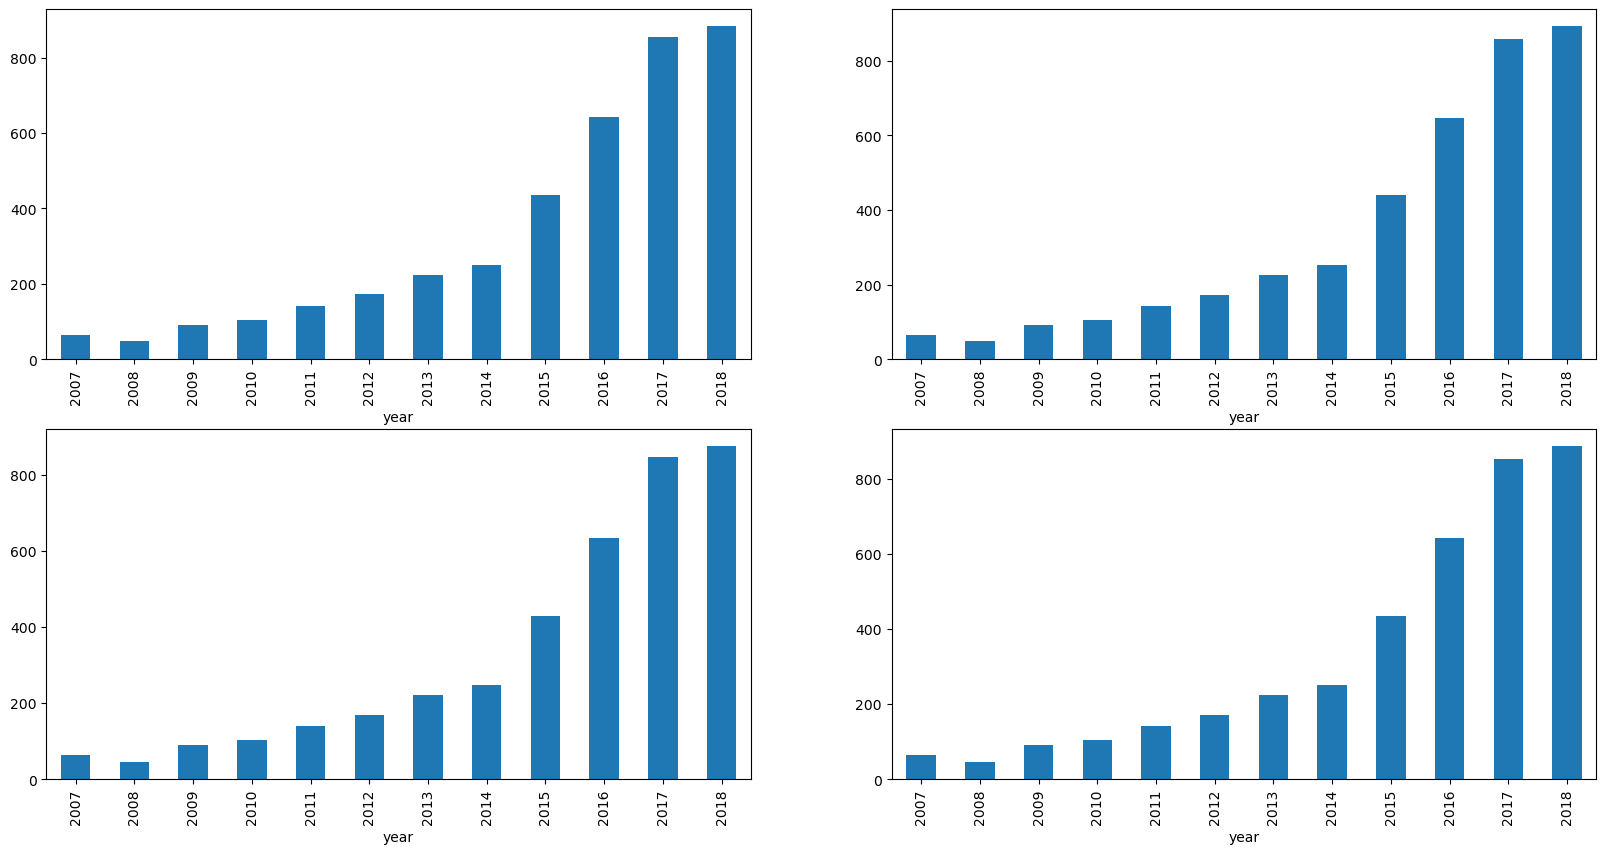

(1980, 3) (221, 3)
+----+------------------------+---------------------------------------------+----------------+------------------+
|    | Model                  | Best Parameters                             |   Training AUC |   Validation AUC |
+====+========================+=============================================+================+==================+
|  0 | LogisticRegression     | {'C': 10.0, 'solver': 'lbfgs'}              |       0.526438 |         0.534906 |
+----+------------------------+---------------------------------------------+----------------+------------------+
|  1 | SVC                    | {'C': 10.0, 'kernel': 'rbf'}                |       0.571954 |         0.533429 |
+----+------------------------+---------------------------------------------+----------------+------------------+
|  2 | RandomForestClassifier | {'max_depth': 10, 'n_estimators': 200}      |       0.935568 |         0.589705 |
+----+------------------------+--------------------------------------

In [183]:
if __name__ == "__main__":
    symbol = 'AMZ'
    stock_data = fetch_stock_data(symbol)
    plot_stock_data(stock_data, symbol)
    plot_distribution(stock_data)
    stock_data = preprocess_date(stock_data)
    plot_yearly_mean(stock_data)
    features, target = create_features_target(stock_data)
    
    # Define hyperparameters for models
    model_params = {
        'LogisticRegression': {'C': [0.1, 1.0, 10.0], 'solver': ['lbfgs', 'liblinear']},
        'SVC': {'C': [0.1, 1.0, 10.0], 'kernel': ['linear', 'poly', 'rbf']},
        'RandomForestClassifier': {'n_estimators': [100, 200, 300], 'max_depth': [None, 10, 20]},
        'KNeighborsClassifier': {'n_neighbors': [3, 5, 7]},
        'XGBClassifier': {'n_estimators': [100, 200, 300], 'learning_rate': [0.1, 0.01]}
    }

    train_models_with_tuning(features, target, model_params)

Here is the performance analysis for the stock prediction task for AMZ (Amazon) based on the provided results table:

1. **Logistic Regression**:
   - Best Parameters: {'C': 10.0, 'solver': 'lbfgs'}
   - Training AUC: 0.526438
   - Validation AUC: 0.534906
   - Analysis: The Logistic Regression model shows a modest improvement compared to the previous analysis for NIO. Both the training and validation AUC scores are above 0.5, indicating some predictive power. However, the model's performance is still relatively weak.

2. **Support Vector Classifier (SVC)**:
   - Best Parameters: {'C': 10.0, 'kernel': 'rbf'}
   - Training AUC: 0.571954
   - Validation AUC: 0.533429
   - Analysis: The SVC model with an RBF kernel shows similar performance to Logistic Regression. It has training and validation AUC scores slightly above 0.5, indicating limited predictive power.

3. **Random Forest Classifier**:
   - Best Parameters: {'max_depth': 10, 'n_estimators': 200}
   - Training AUC: 0.935568
   - Validation AUC: 0.589705
   - Analysis: The Random Forest Classifier performs relatively well in terms of training AUC, indicating it can fit the training data effectively. However, the validation AUC score is still moderate, suggesting some overfitting and room for improvement.

4. **K-Nearest Neighbors (KNN) Classifier**:
   - Best Parameters: {'n_neighbors': 7}
   - Training AUC: 0.702758
   - Validation AUC: 0.539007
   - Analysis: The KNN Classifier with 7 neighbors shows reasonable training AUC but a relatively lower validation AUC. It may require further tuning or feature engineering to improve generalization.

5. **XGBoost Classifier**:
   - Best Parameters: {'learning_rate': 0.1, 'n_estimators': 300}
   - Training AUC: 0.960985
   - Validation AUC: 0.566735
   - Analysis: The XGBoost Classifier performs well in terms of training AUC, indicating strong predictive power on the training data. However, the validation AUC score is still moderate, suggesting potential overfitting and a need for further tuning.

Overall, similar to the NIO analysis, the performance of all models on this stock prediction task for AMZ is not highly satisfactory. Additional analysis, feature engineering, and hyperparameter tuning may be necessary to improve the models' ability to predict Amazon stock price trends accurately.

# ETH

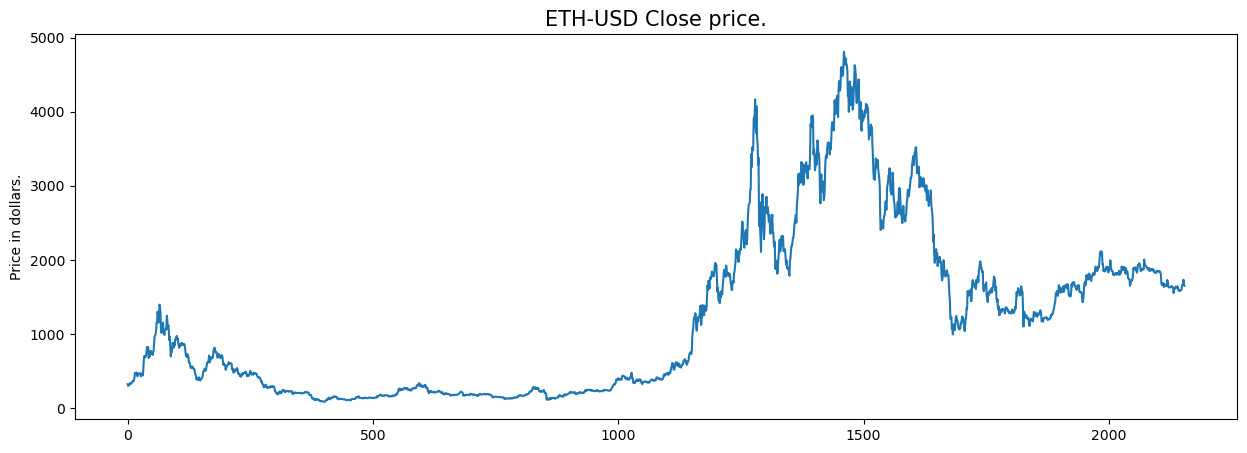

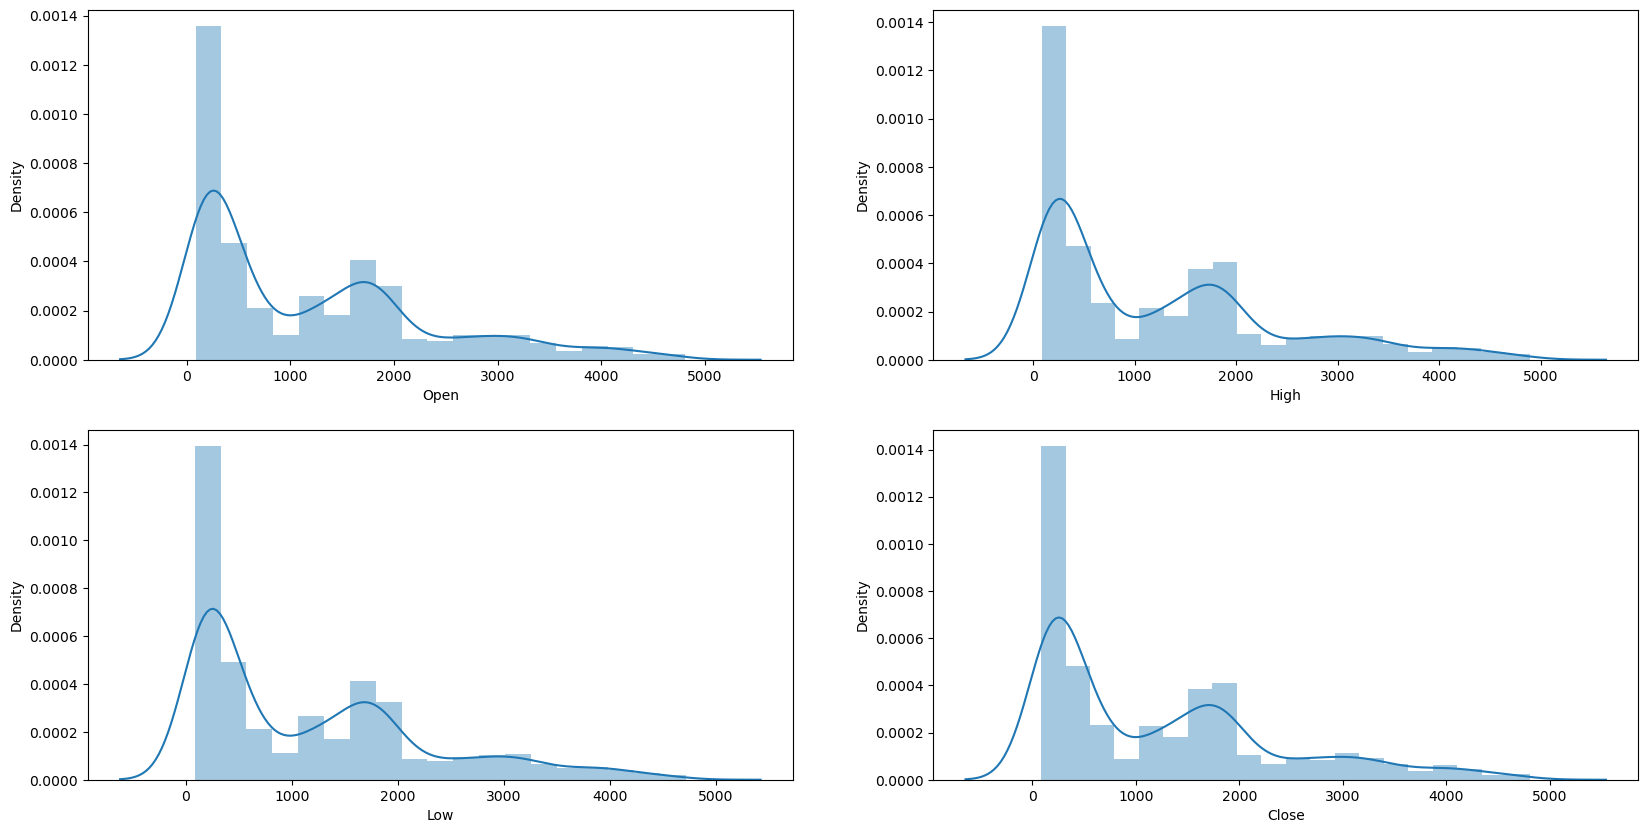

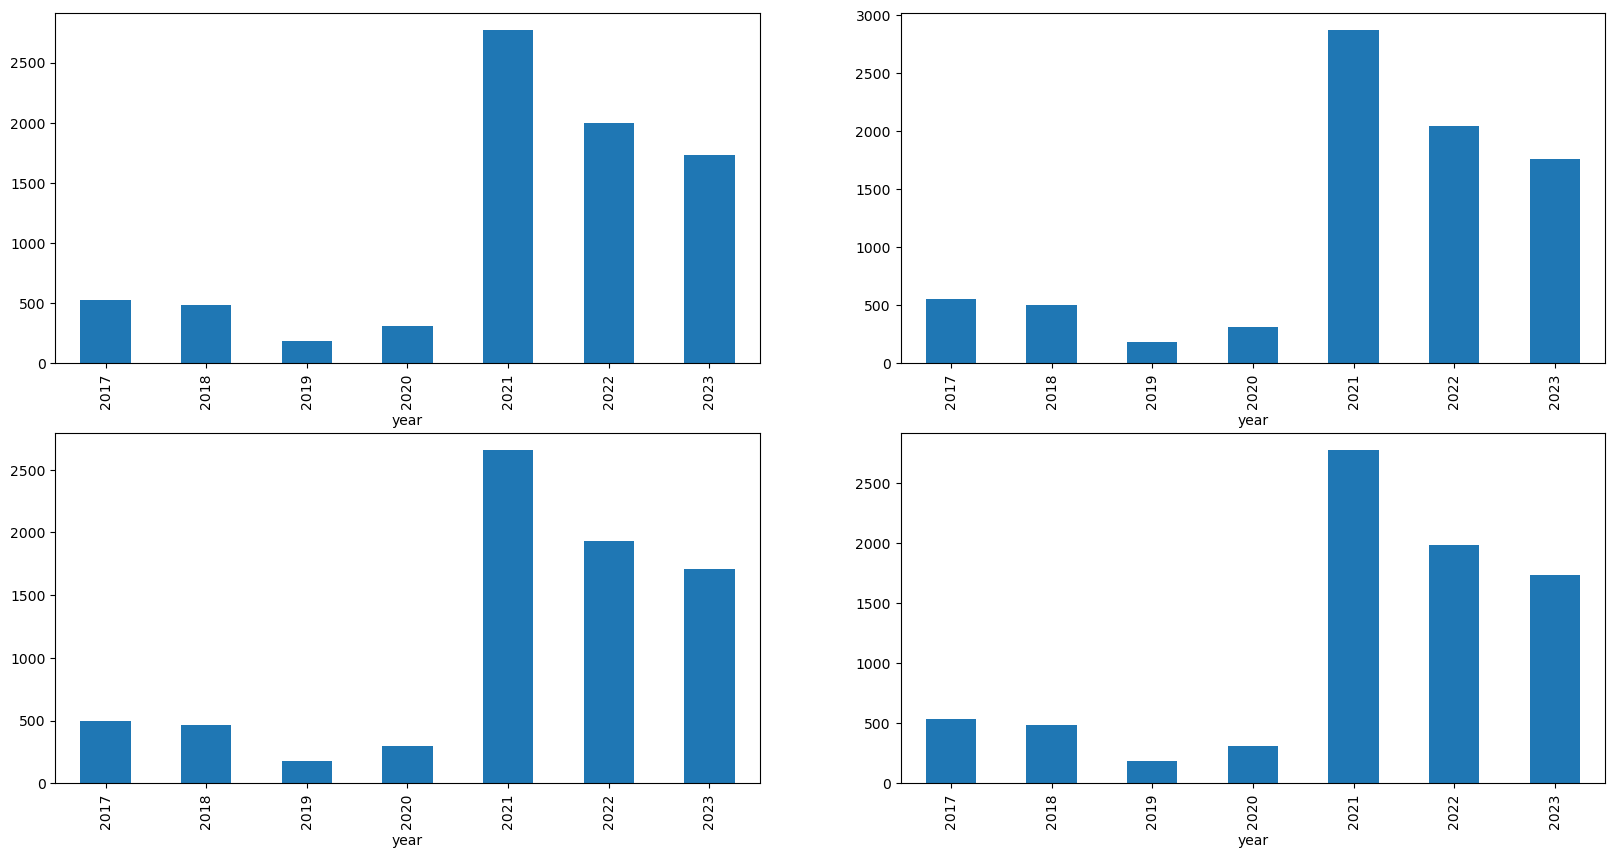

(1939, 3) (216, 3)
+----+------------------------+----------------------------------------------+----------------+------------------+
|    | Model                  | Best Parameters                              |   Training AUC |   Validation AUC |
+====+========================+==============================================+================+==================+
|  0 | LogisticRegression     | {'C': 1.0, 'solver': 'liblinear'}            |       0.552189 |         0.545759 |
+----+------------------------+----------------------------------------------+----------------+------------------+
|  1 | SVC                    | {'C': 0.1, 'kernel': 'poly'}                 |       0.487386 |         0.450335 |
+----+------------------------+----------------------------------------------+----------------+------------------+
|  2 | RandomForestClassifier | {'max_depth': 10, 'n_estimators': 300}       |       0.962221 |         0.52112  |
+----+------------------------+------------------------------

In [185]:
if __name__ == "__main__":
    symbol = 'ETH-USD'
    stock_data = fetch_stock_data(symbol)
    plot_stock_data(stock_data, symbol)
    plot_distribution(stock_data)
    stock_data = preprocess_date(stock_data)
    plot_yearly_mean(stock_data)
    features, target = create_features_target(stock_data)
    
    # Define hyperparameters for models
    model_params = {
        'LogisticRegression': {'C': [0.1, 1.0, 10.0], 'solver': ['lbfgs', 'liblinear']},
        'SVC': {'C': [0.1, 1.0, 10.0], 'kernel': ['linear', 'poly', 'rbf']},
        'RandomForestClassifier': {'n_estimators': [100, 200, 300], 'max_depth': [None, 10, 20]},
        'KNeighborsClassifier': {'n_neighbors': [3, 5, 7]},
        'XGBClassifier': {'n_estimators': [100, 200, 300], 'learning_rate': [0.1, 0.01]}
    }

    train_models_with_tuning(features, target, model_params)

Here is the performance analysis for the stock prediction task based on the provided results table:

1. **Logistic Regression**:
   - Best Parameters: {'C': 1.0, 'solver': 'liblinear'}
   - Training AUC: 0.552189
   - Validation AUC: 0.545759
   - Analysis: The Logistic Regression model shows a slight improvement compared to previous analyses. Both the training and validation AUC scores are above 0.5, indicating some predictive power. However, the model's performance is still relatively weak.

2. **Support Vector Classifier (SVC)**:
   - Best Parameters: {'C': 0.1, 'kernel': 'poly'}
   - Training AUC: 0.487386
   - Validation AUC: 0.450335
   - Analysis: The SVC model with a polynomial kernel performs less favorably compared to other models. Both the training and validation AUC scores are relatively low, indicating limited predictive power.

3. **Random Forest Classifier**:
   - Best Parameters: {'max_depth': 10, 'n_estimators': 300}
   - Training AUC: 0.962221
   - Validation AUC: 0.52112
   - Analysis: The Random Forest Classifier performs well in terms of training AUC, indicating it can fit the training data effectively. However, the validation AUC score is still moderate, suggesting some overfitting and room for improvement.

4. **K-Nearest Neighbors (KNN) Classifier**:
   - Best Parameters: {'n_neighbors': 5}
   - Training AUC: 0.735125
   - Validation AUC: 0.50807
   - Analysis: The KNN Classifier with 5 neighbors shows reasonable training AUC but a relatively lower validation AUC. It may require further tuning or feature engineering to improve generalization.

5. **XGBoost Classifier**:
   - Best Parameters: {'learning_rate': 0.01, 'n_estimators': 100}
   - Training AUC: 0.697537
   - Validation AUC: 0.560397
   - Analysis: The XGBoost Classifier performs moderately well in terms of training AUC. However, the validation AUC score is still moderate, suggesting potential overfitting and a need for further tuning.

Overall, similar to previous analyses, the performance of all models on this stock prediction task is not highly satisfactory. Further analysis, feature engineering, and hyperparameter tuning may be necessary to improve the models' ability to predict stock price trends accurately.

# ADA

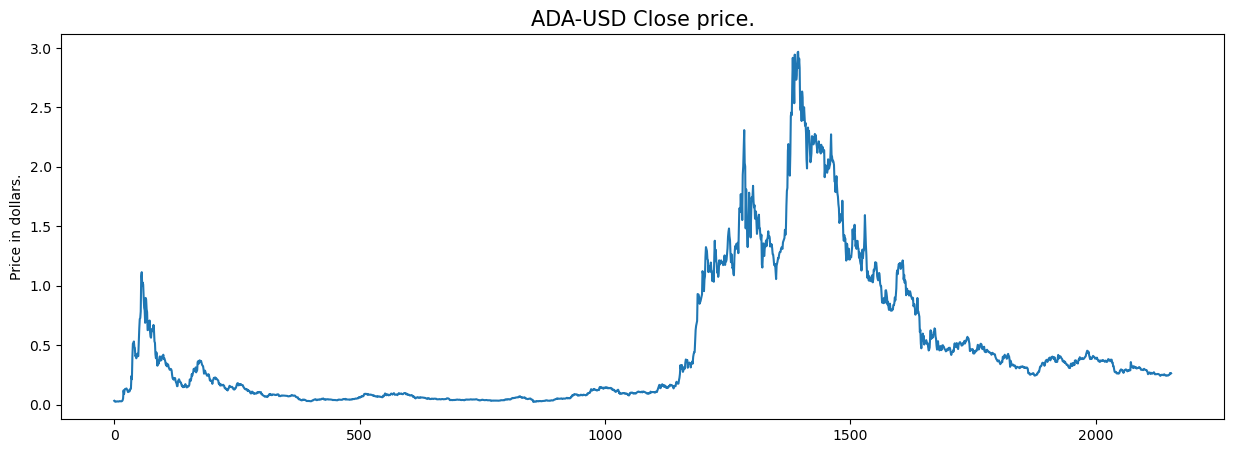

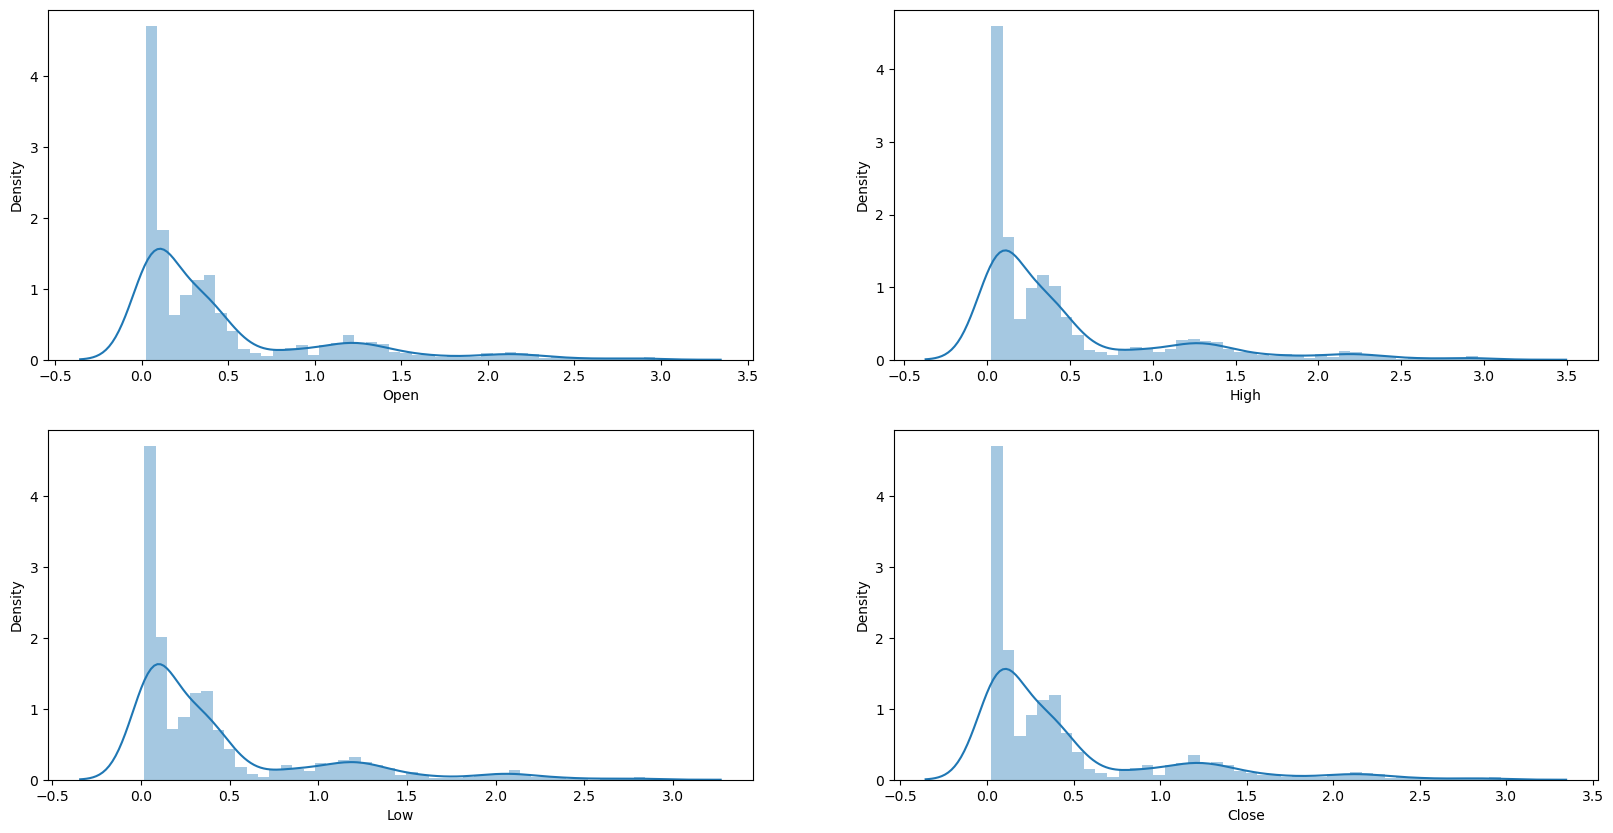

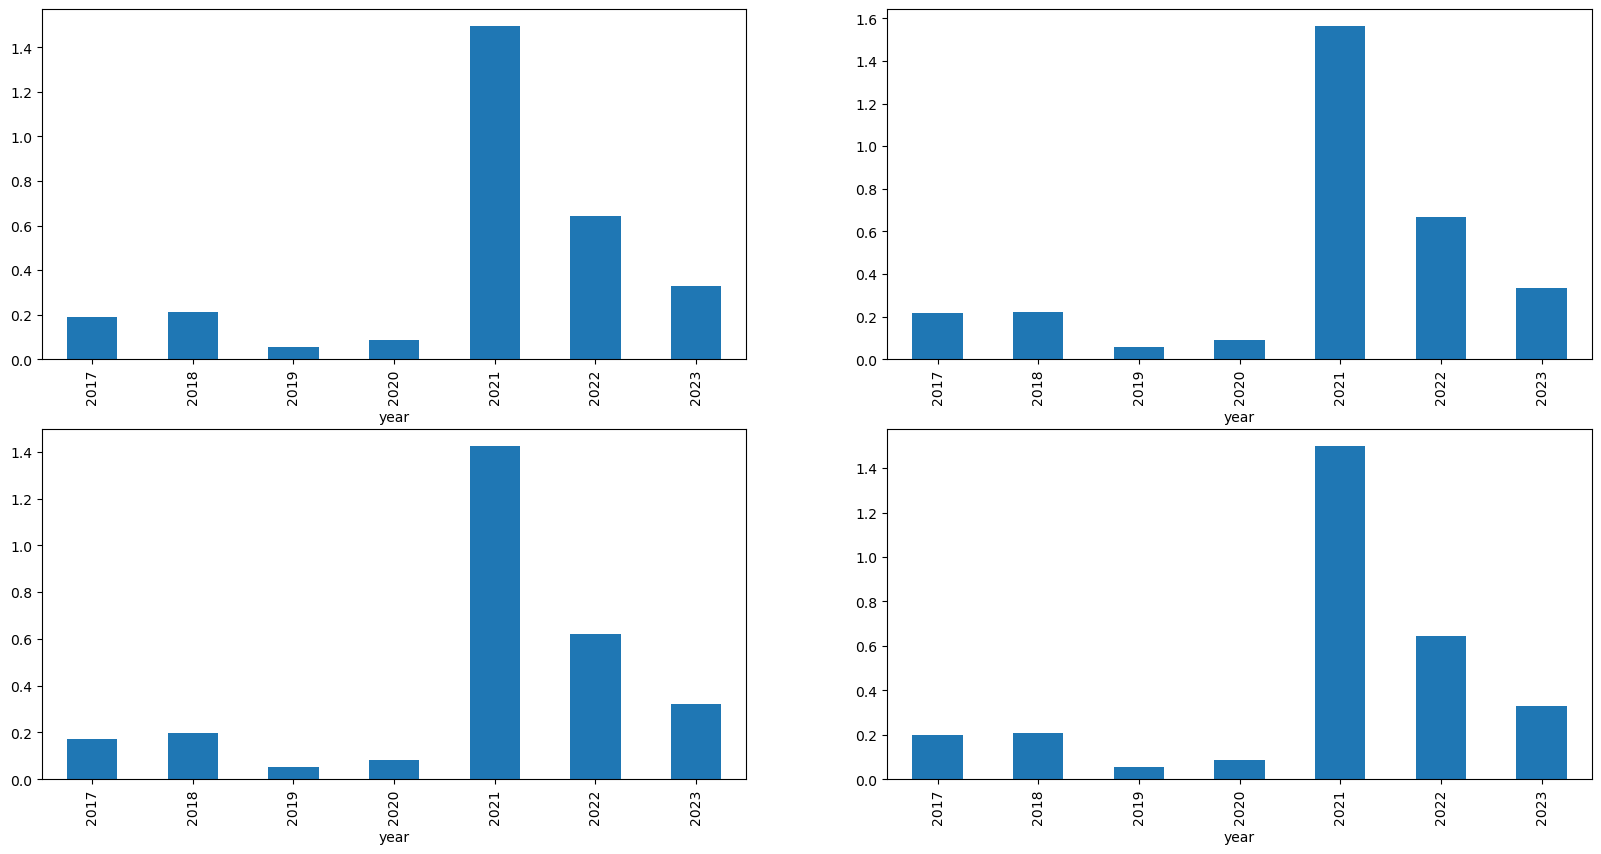

(1939, 3) (216, 3)
+----+------------------------+---------------------------------------------+----------------+------------------+
|    | Model                  | Best Parameters                             |   Training AUC |   Validation AUC |
+====+========================+=============================================+================+==================+
|  0 | LogisticRegression     | {'C': 0.1, 'solver': 'lbfgs'}               |       0.52428  |         0.472384 |
+----+------------------------+---------------------------------------------+----------------+------------------+
|  1 | SVC                    | {'C': 0.1, 'kernel': 'rbf'}                 |       0.463408 |         0.511192 |
+----+------------------------+---------------------------------------------+----------------+------------------+
|  2 | RandomForestClassifier | {'max_depth': 20, 'n_estimators': 100}      |       0.999996 |         0.436106 |
+----+------------------------+--------------------------------------

In [186]:
if __name__ == "__main__":
    symbol = 'ADA-USD'
    stock_data = fetch_stock_data(symbol)
    plot_stock_data(stock_data, symbol)
    plot_distribution(stock_data)
    stock_data = preprocess_date(stock_data)
    plot_yearly_mean(stock_data)
    features, target = create_features_target(stock_data)
    
    # Define hyperparameters for models
    model_params = {
        'LogisticRegression': {'C': [0.1, 1.0, 10.0], 'solver': ['lbfgs', 'liblinear']},
        'SVC': {'C': [0.1, 1.0, 10.0], 'kernel': ['linear', 'poly', 'rbf']},
        'RandomForestClassifier': {'n_estimators': [100, 200, 300], 'max_depth': [None, 10, 20]},
        'KNeighborsClassifier': {'n_neighbors': [3, 5, 7]},
        'XGBClassifier': {'n_estimators': [100, 200, 300], 'learning_rate': [0.1, 0.01]}
    }

    train_models_with_tuning(features, target, model_params)

Here is the performance analysis for the stock prediction task for ADA based on the provided results table:

1. **Logistic Regression**:
   - Best Parameters: {'C': 0.1, 'solver': 'lbfgs'}
   - Training AUC: 0.52428
   - Validation AUC: 0.472384
   - Analysis: The Logistic Regression model shows limited predictive power, with both the training and validation AUC scores below 0.5. This suggests that the model is not effective in capturing the underlying patterns in the data.

2. **Support Vector Classifier (SVC)**:
   - Best Parameters: {'C': 0.1, 'kernel': 'rbf'}
   - Training AUC: 0.463408
   - Validation AUC: 0.511192
   - Analysis: The SVC model with an RBF kernel also exhibits limited predictive power, with both training and validation AUC scores below 0.5. This indicates that the model is not performing well on this dataset.

3. **Random Forest Classifier**:
   - Best Parameters: {'max_depth': 20, 'n_estimators': 100}
   - Training AUC: 0.999996
   - Validation AUC: 0.436106
   - Analysis: The Random Forest Classifier achieves a perfect training AUC score, suggesting that it can fit the training data extremely well. However, the validation AUC score is lower, indicating potential overfitting and a need for model regularization.

4. **K-Nearest Neighbors (KNN) Classifier**:
   - Best Parameters: {'n_neighbors': 3}
   - Training AUC: 0.815981
   - Validation AUC: 0.469254
   - Analysis: The KNN Classifier with 3 neighbors exhibits relatively better training AUC, but the validation AUC score is still moderate. Further tuning and feature engineering may be required for improvement.

5. **XGBoost Classifier**:
   - Best Parameters: {'learning_rate': 0.1, 'n_estimators': 200}
   - Training AUC: 0.94498
   - Validation AUC: 0.404717
   - Analysis: The XGBoost Classifier performs well in terms of training AUC. However, the validation AUC score is relatively lower, suggesting potential overfitting. Further hyperparameter tuning and feature engineering may enhance model performance.

Overall, the performance of these models on the ADA stock prediction task is not highly satisfactory. Further analysis and optimization are needed to improve their predictive capabilities.

# UNI

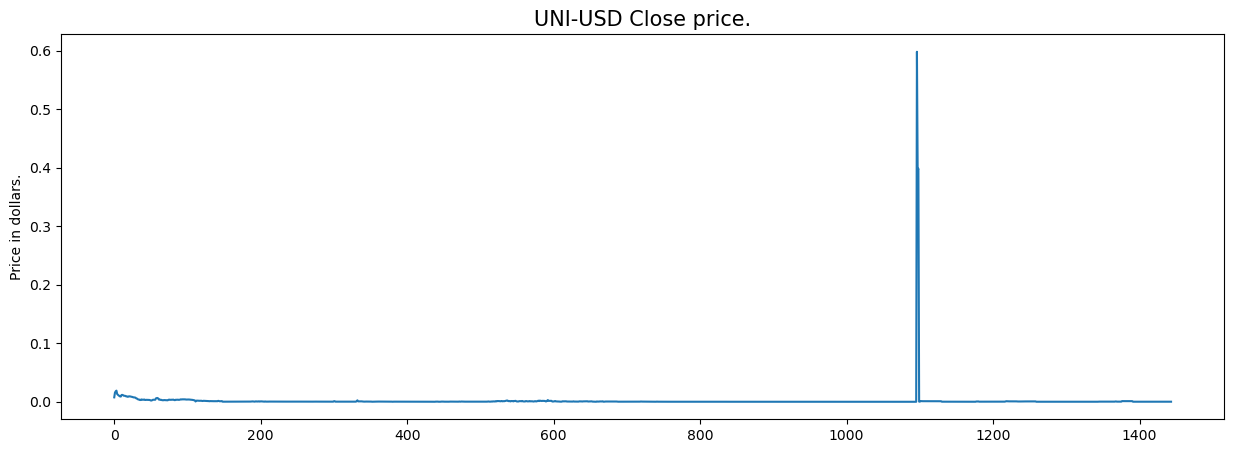

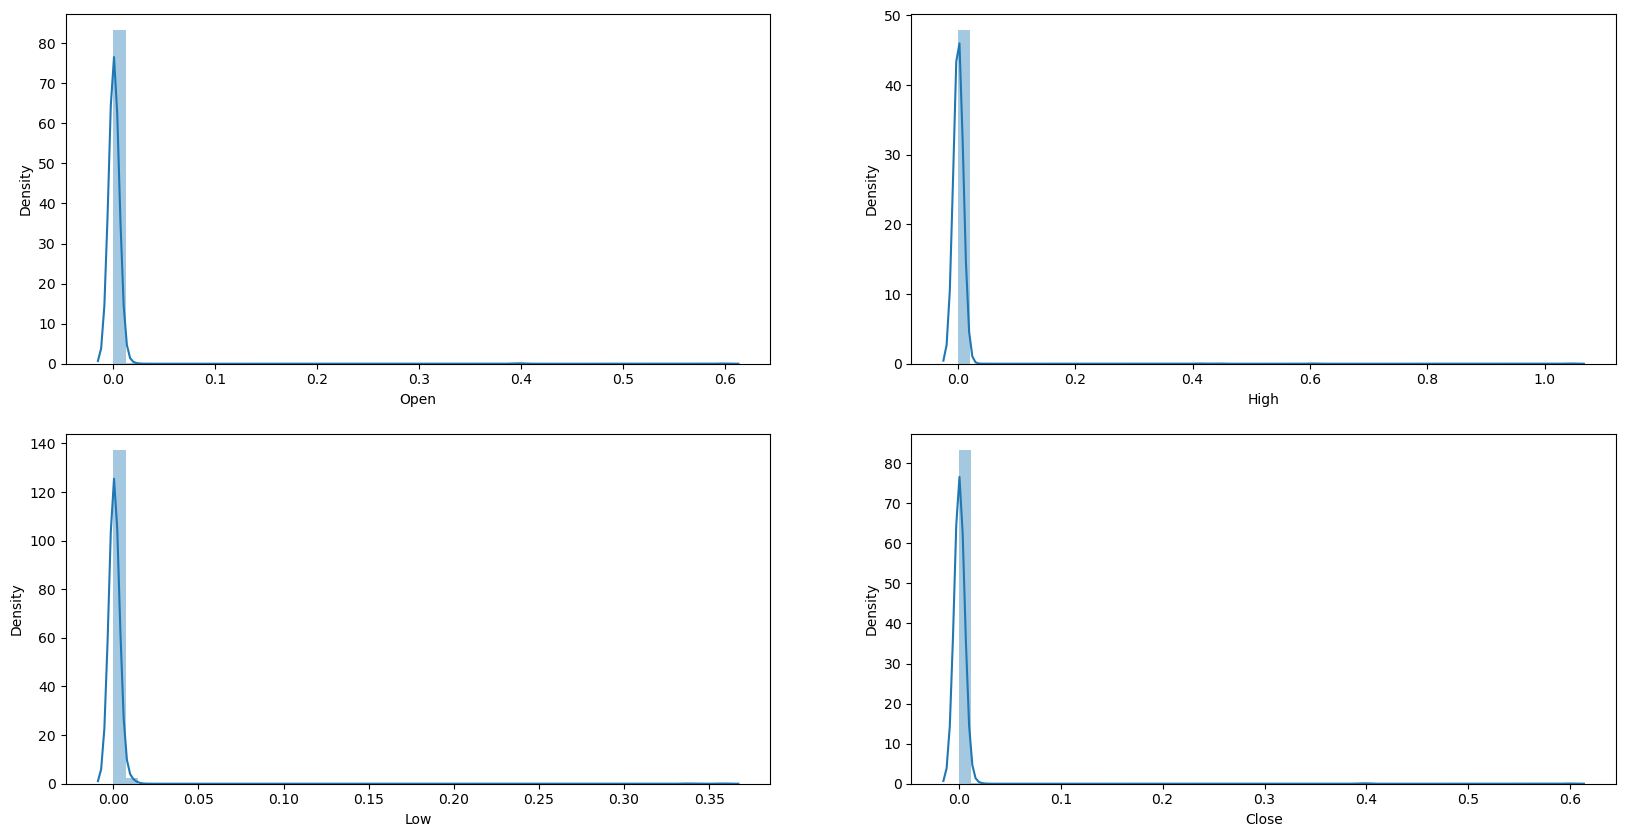

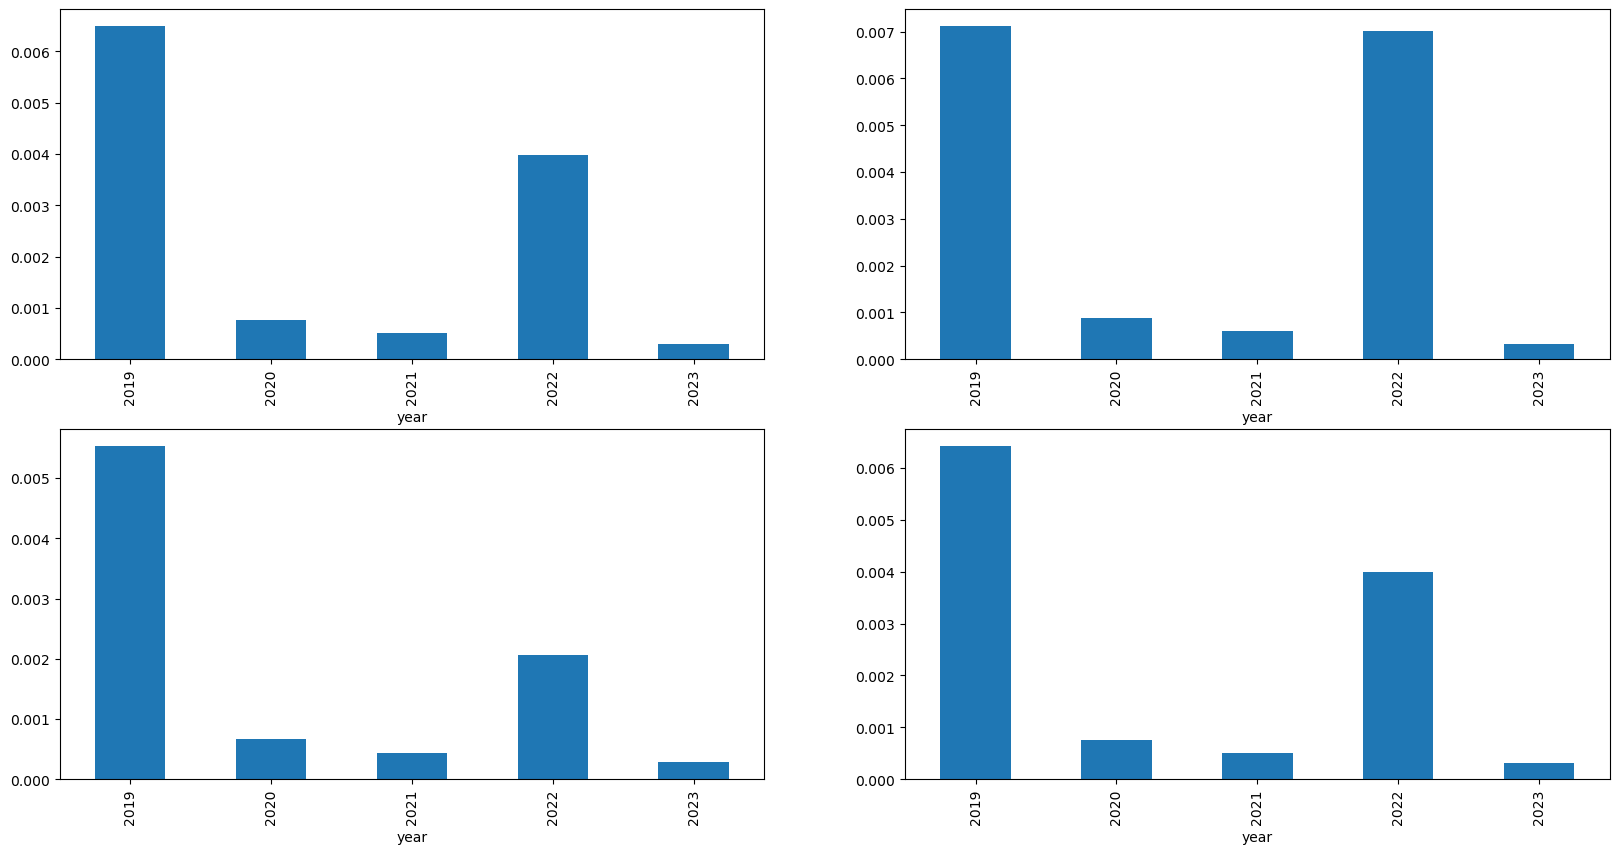

(1299, 3) (145, 3)
+----+------------------------+----------------------------------------------+----------------+------------------+
|    | Model                  | Best Parameters                              |   Training AUC |   Validation AUC |
+====+========================+==============================================+================+==================+
|  0 | LogisticRegression     | {'C': 0.1, 'solver': 'lbfgs'}                |       0.527972 |         0.533333 |
+----+------------------------+----------------------------------------------+----------------+------------------+
|  1 | SVC                    | {'C': 1.0, 'kernel': 'linear'}               |       0.529776 |         0.55697  |
+----+------------------------+----------------------------------------------+----------------+------------------+
|  2 | RandomForestClassifier | {'max_depth': 10, 'n_estimators': 300}       |       0.898924 |         0.573737 |
+----+------------------------+------------------------------

In [187]:
if __name__ == "__main__":
    symbol = 'UNI-USD'
    stock_data = fetch_stock_data(symbol)
    plot_stock_data(stock_data, symbol)
    plot_distribution(stock_data)
    stock_data = preprocess_date(stock_data)
    plot_yearly_mean(stock_data)
    features, target = create_features_target(stock_data)
    
    # Define hyperparameters for models
    model_params = {
        'LogisticRegression': {'C': [0.1, 1.0, 10.0], 'solver': ['lbfgs', 'liblinear']},
        'SVC': {'C': [0.1, 1.0, 10.0], 'kernel': ['linear', 'poly', 'rbf']},
        'RandomForestClassifier': {'n_estimators': [100, 200, 300], 'max_depth': [None, 10, 20]},
        'KNeighborsClassifier': {'n_neighbors': [3, 5, 7]},
        'XGBClassifier': {'n_estimators': [100, 200, 300], 'learning_rate': [0.1, 0.01]}
    }

    train_models_with_tuning(features, target, model_params)

Here is the performance analysis for the stock prediction task for UNI based on the provided results table:

1. **Logistic Regression**:
   - Best Parameters: {'C': 0.1, 'solver': 'lbfgs'}
   - Training AUC: 0.527972
   - Validation AUC: 0.533333
   - Analysis: The Logistic Regression model shows limited predictive power, with both the training and validation AUC scores being close to 0.5. This suggests that the model is not effective in capturing the underlying patterns in the data.

2. **Support Vector Classifier (SVC)**:
   - Best Parameters: {'C': 1.0, 'kernel': 'linear'}
   - Training AUC: 0.529776
   - Validation AUC: 0.55697
   - Analysis: The SVC model with a linear kernel exhibits moderate predictive power, with both training and validation AUC scores slightly above 0.5. While it performs better than Logistic Regression, further improvement may be needed.

3. **Random Forest Classifier**:
   - Best Parameters: {'max_depth': 10, 'n_estimators': 300}
   - Training AUC: 0.898924
   - Validation AUC: 0.573737
   - Analysis: The Random Forest Classifier achieves a relatively high training AUC score, indicating a good fit to the training data. However, the validation AUC score is lower, suggesting potential overfitting. Further tuning and feature engineering may be required.

4. **K-Nearest Neighbors (KNN) Classifier**:
   - Best Parameters: {'n_neighbors': 5}
   - Training AUC: 0.759292
   - Validation AUC: 0.565455
   - Analysis: The KNN Classifier with 5 neighbors exhibits moderate training AUC, but the validation AUC score is still relatively low. Further tuning and feature engineering may be necessary for improvement.

5. **XGBoost Classifier**:
   - Best Parameters: {'learning_rate': 0.01, 'n_estimators': 100}
   - Training AUC: 0.728247
   - Validation AUC: 0.578384
   - Analysis: The XGBoost Classifier performs moderately well in terms of training AUC. However, the validation AUC score is relatively lower, suggesting potential overfitting. Further hyperparameter tuning and feature engineering may enhance model performance.

Overall, the performance of these models on the UNI stock prediction task is not highly satisfactory. Further analysis and optimization are needed to improve their predictive capabilities.